<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/experiments/llm_openai_vs_claude_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

## Experimenting with different LLMs - GPT-4 vs Gemma 7B

**Overview**: In this notebook, we will compare different LLM providers - specifically GPT-4 vs Gemma-7B. We will be using around 30 randomly picked examples from the Financial QA dataset and evaluate the response on different criteria to determine which of the two models performs better.

We have used the following 5 metrics from UpTrain's library:

1. [Response Conciseness](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-conciseness): Evaluates how concise the generated response is or if it has any additional irrelevant information for the question asked.

2. [Response Matching](https://docs.uptrain.ai/predefined-evaluations/ground-truth-comparison/response-matching): Evaluates how well the response generated by the LLM aligns with the provided ground truth.

3. [Factual Accuracy](https://docs.uptrain.ai/predefined-evaluations/context-awareness/factual-accuracy): Evaluates whether the response generated is factually correct and grounded by the provided context.

4. [Context Utilization](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-utilization): Evaluates how complete the generated response is for the question specified given the information provided in the context. Also known as Reponse Completeness wrt context

5. [Response Relevance](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-relevance): Evaluates how relevant the generated response was to the question specified.

Each score has a value between 0 and 1. 

You can look at the complete list of UpTrain's supported metrics [here](https://docs.uptrain.ai/predefined-evaluations/overview)

### Install Dependencies

In [1]:
# %pip install openai uptrain

### Authentication 

Let's define the required api keys - mainly the openai key (for generating responses on GPT-4), anyscale api key (for generating responses using Gemma-7B).

Here, we are using Gemma 7B model hosted on [Anyscale](https://www.anyscale.com/). You can get your Anyscale API key [here](https://app.endpoints.anyscale.com/credentials). 

In [2]:
import polars as pl 
import os

from uptrain import EvalLLM, Evals, ResponseMatching
import openai

OPENAI_API_KEY = "sk-*****************"

/Users/shreyanshjain/Documents/UpTrain/GitHub_Clone/uptrain/.venv/lib/python3.11/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


### Download the testing dataset

Note: Ground Truth is optional as UpTrain supports many checks (like factual accuracy, response relevance, etc. which doesn't require ground truth). Though, for this experiment we will be needing Ground Truth (as it is required for response matching)

In [3]:
url = "https://uptrain-assets.s3.ap-south-1.amazonaws.com/data/benchmark.jsonl"
dataset_path = os.path.join('./', "benchmark.jsonl")

if not os.path.exists(dataset_path):
    import httpx
    r = httpx.get(url)
    with open(dataset_path, "wb") as f:
        f.write(r.content)  

dataset = pl.read_ndjson(dataset_path).select(pl.col(["question", "ground_truth", "context"]))
print(dataset)

shape: (28, 3)
┌────────────────────────────────┬────────────────────────────────┬────────────────────────────────┐
│ question                       ┆ ground_truth                   ┆ context                        │
│ ---                            ┆ ---                            ┆ ---                            │
│ str                            ┆ str                            ┆ str                            │
╞════════════════════════════════╪════════════════════════════════╪════════════════════════════════╡
│ Do the activities of my LLC    ┆ No. When you file your         ┆ It really depends on the type  │
│ need…                          ┆ Articles …                     ┆ of…                            │
│ How much house can I afford,   ┆ On $4K/mo gross about $1000/mo ┆ There is no simple way to      │
│ wai…                           ┆ c…                             ┆ calcul…                        │
│ Will Short Sale Prevent Me     ┆ From MyFICO: A foreclosure     ┆ No that 

### Let's define Anyscale Client to use Gemma 7B

In [4]:
ANYSCALE_API_KEY = "esecret_************"

client = openai.OpenAI(
    base_url = "https://api.endpoints.anyscale.com/v1",
    api_key = ANYSCALE_API_KEY
)

### Let's define a simple prompt to generate responses

In [5]:
def get_response(row, model):
    question = row['question'][0]
    context = row['context'][0]
    prompt = f"""
        Answer the following user query using the retrieved document in less than 3 sentences:
        {question}
        The retrieved document has the following text:
        {context}

        Answer:
    """

    if "gpt" in model:
        response = openai.chat.completions.create(
            model=model, messages=[{"role": "system", "content": prompt}]
        ).choices[0].message.content
    elif "gemma-7b" in model:        
        response = client.chat.completions.create(
            model="google/gemma-7b-it",
            messages=[
                    {"role": "user", "content": prompt}],
            temperature=0.1
        ).choices[0].message.content
    
    return {'question': question, 'context': context, 'response': response, 'ground_truth': row['ground_truth'][0], 'model': model}

### Generate responses for both the models

In [6]:
results_oai = [get_response(dataset[idx], 'gpt-4') for idx in range(len(dataset))]
results_gemma = [get_response(dataset[idx], 'gemma-7b') for idx in range(len(dataset))]

### Evaluating Experiments using UpTrain

UpTrain's EvalLLM provides an `evaluate_experiments` method which takes the input data to be evaluated along with the list of checks to be run and the name of the columns associated with the experiment. 

In this example, we are generating responses in the notebook itself but you can imagine generating responses via your own setup and just passing the query-response pair to UpTrain for evaluation 

In [7]:
from uptrain import EvalLLM, Evals, ResponseMatching
import nest_asyncio
nest_asyncio.apply()

eval_llm = EvalLLM(openai_api_key = OPENAI_API_KEY)

res = eval_llm.evaluate_experiments(
    project_name = "Gpt4-vs-Gemma7B-experiment",
    data = results_oai + results_gemma,
    checks = [
       Evals.RESPONSE_CONCISENESS,
       ResponseMatching(method = 'llm'),    # comment this line if your data doesn't have a ground_truth
       Evals.RESPONSE_RELEVANCE,
       Evals.RESPONSE_COMPLETENESS_WRT_CONTEXT,
       Evals.FACTUAL_ACCURACY,
    ],
    exp_columns=['model']
)

100%|██████████| 56/56 [00:15<00:00,  3.67it/s]


### Visualize Results

You can also visualize these results using our dashboards.

These dashboards are a part of our Open Source Offering. You can check it out on our [Github](https://github.com/uptrain-ai/uptrain).

You can run these dashboards locally on your system, check out our [documentation](https://docs.uptrain.ai/dashboard/getting_started) to get started.

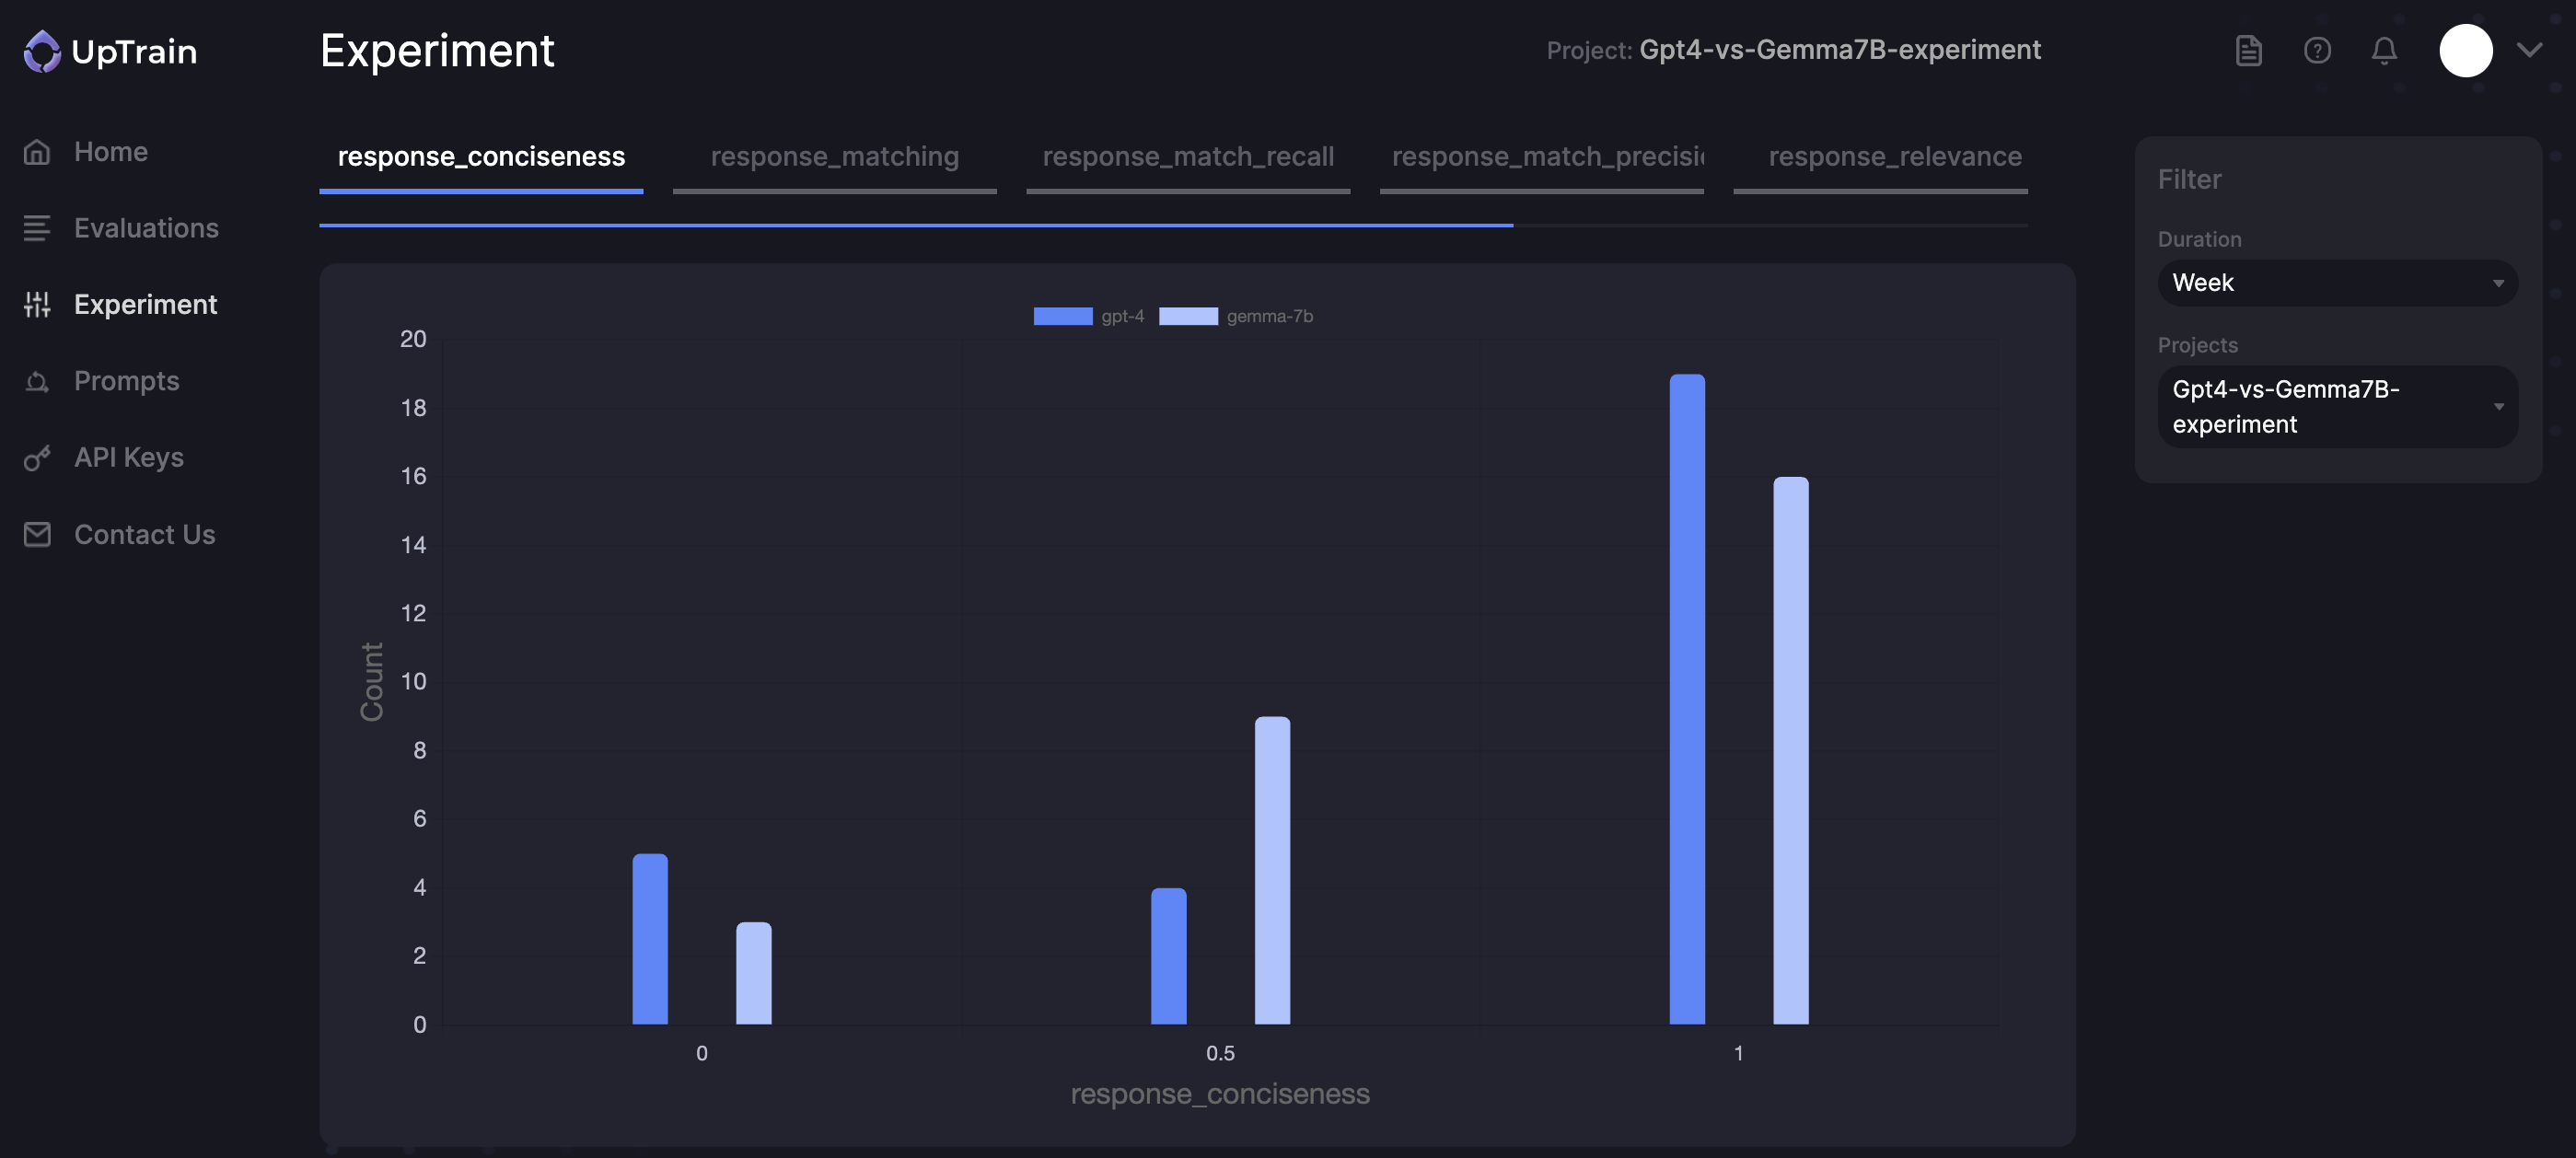

Using UpTrain dashboards you can also see logs of individual data points and get key insights

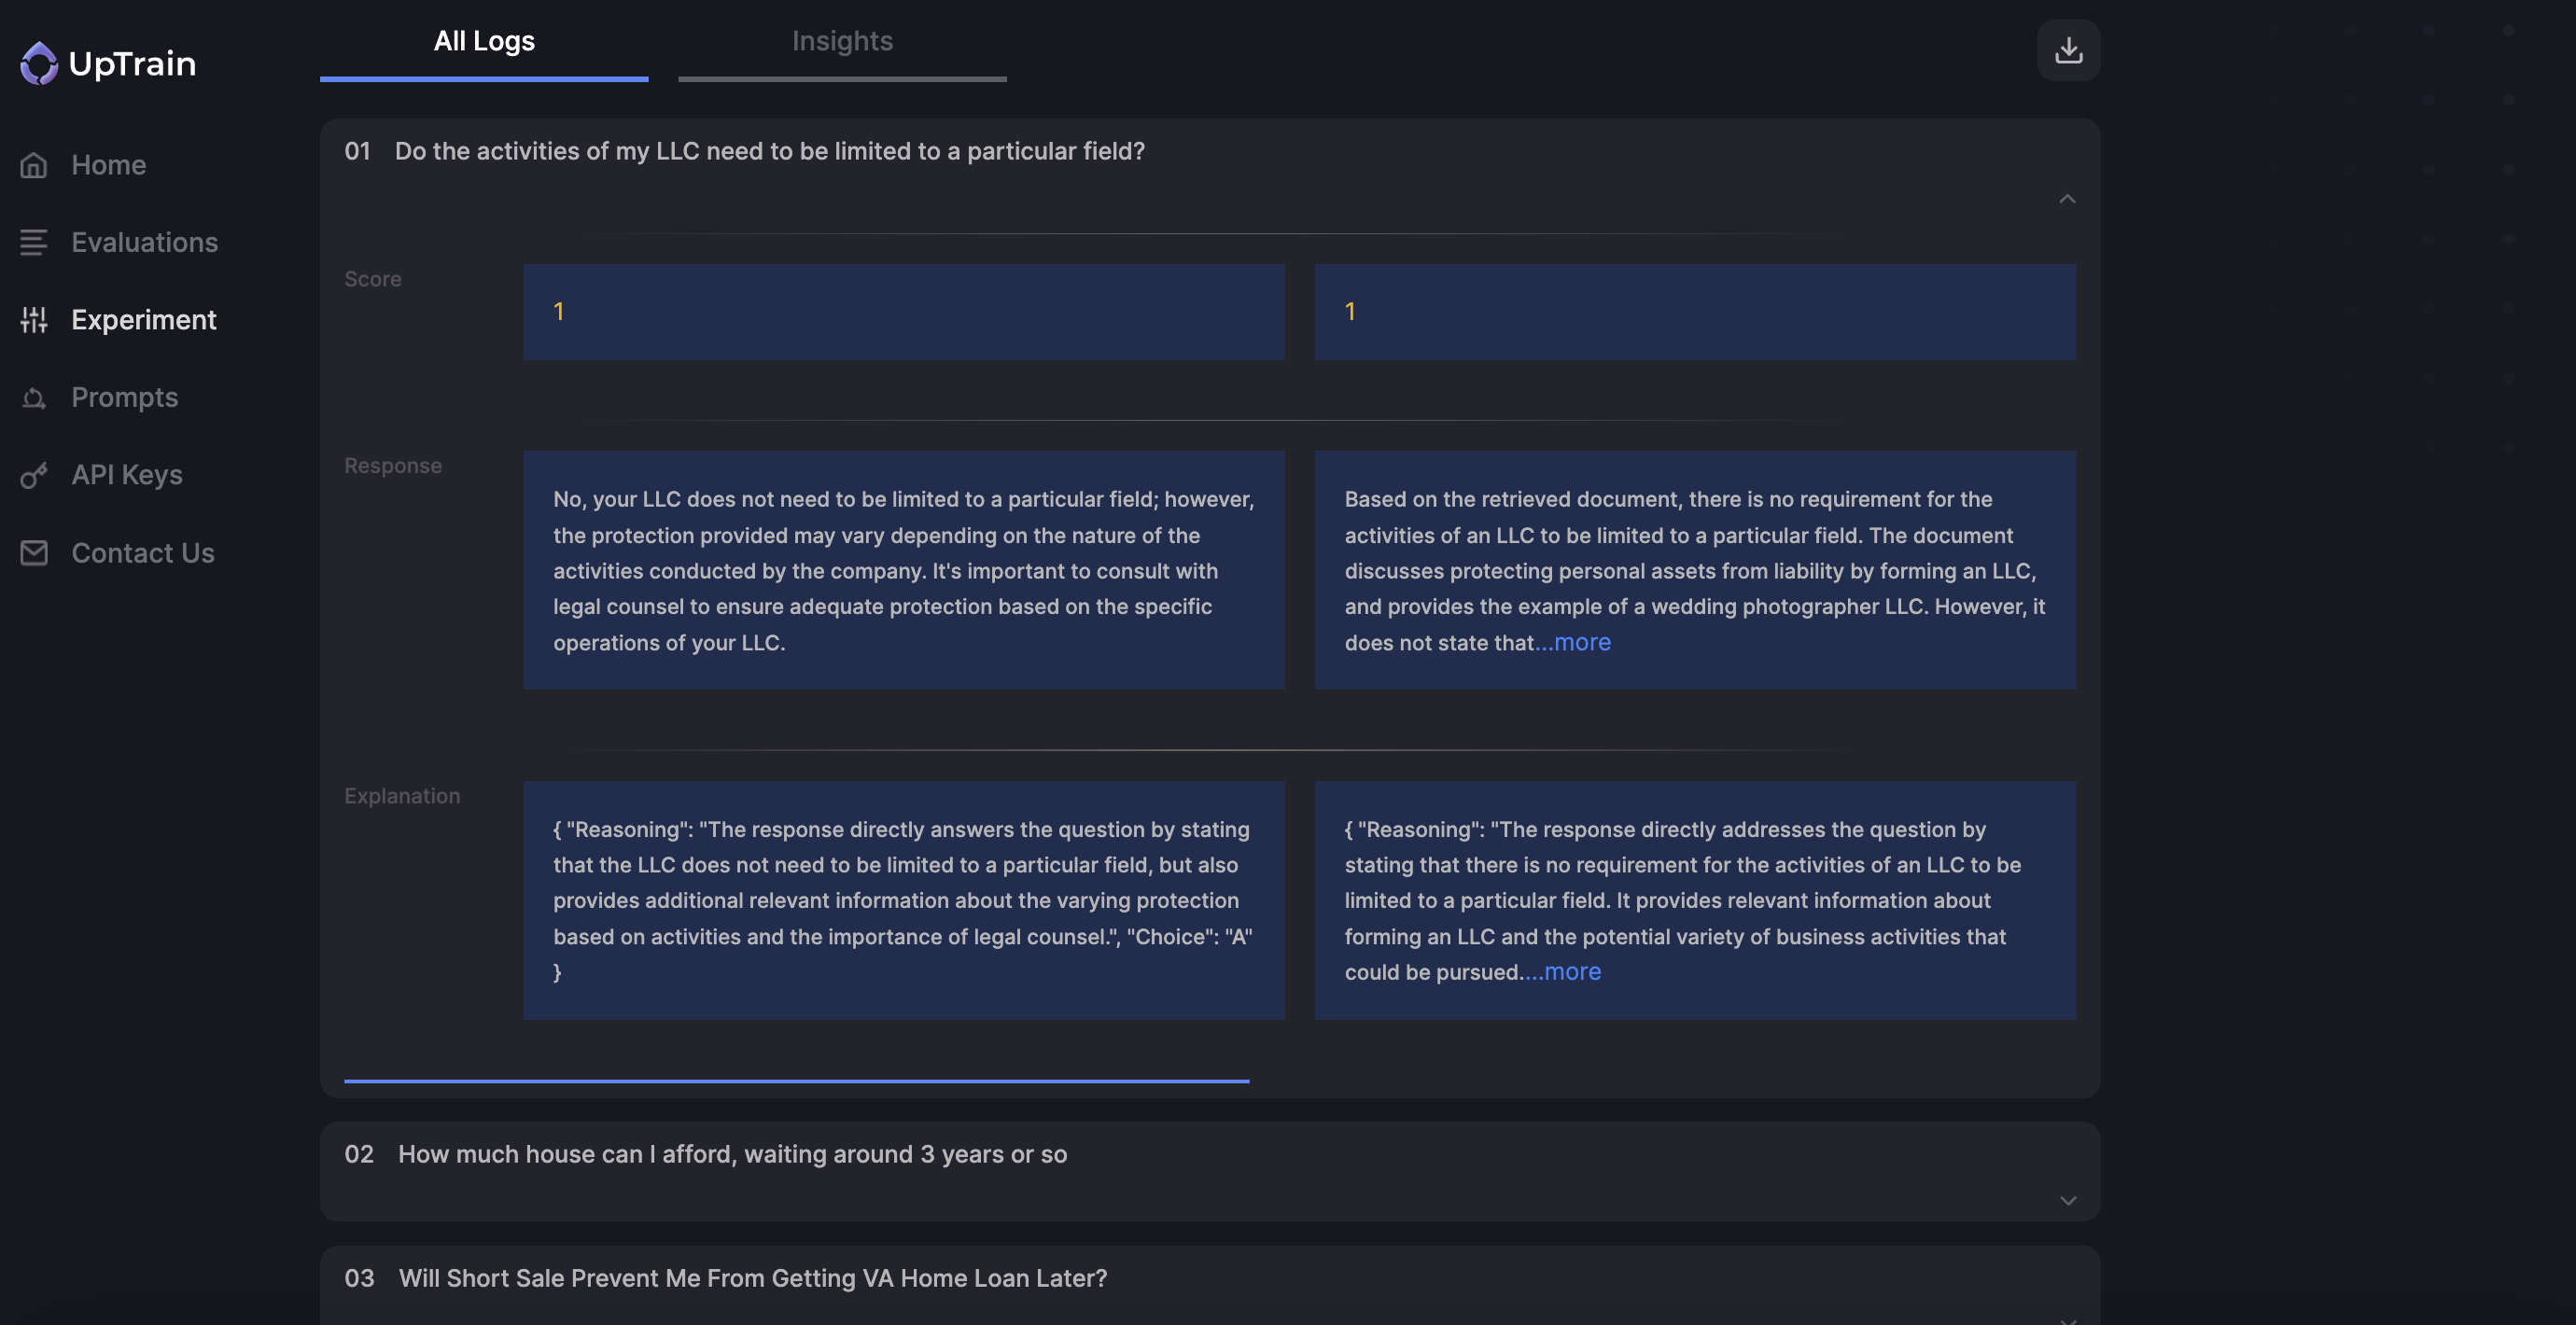